TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors)
==================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico, using a sinogram
computed with the astra projector.

In [1]:
import numpy as np

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import Parallel2dProjector, XRayTransform, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = snp.array(discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N))

det_count = N
det_spacing = np.sqrt(2)

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
projectors = {
    "astra": astra.XRayTransform2D(
        x_gt.shape, det_count, det_spacing, angles - np.pi / 2.0
    ),  # astra
    "svmbir": svmbir.XRayTransform(
        x_gt.shape, 2 * np.pi - angles, det_count, delta_pixel=1.0, delta_channel=det_spacing
    ),  # svmbir
    "scico": XRayTransform(
        Parallel2dProjector((N, N), angles, det_count=det_count, dx=1 / det_spacing)
    ),  # scico
}

Compute common sinogram using astra projector.

In [4]:
A = projectors["astra"]
noise = np.random.normal(size=(n_projection, det_count)).astype(np.float32)
y = A @ x_gt + 2.0 * noise

Construct initial solution for regularized problem.

In [5]:
x0 = A.fbp(y)

Solve the same problem using the different projectors.

In [6]:
print(f"Solving on {device_info()}")
x_rec, hist = {}, {}
for p in projectors.keys():
    print(f"\nSolving with {p} projector")

    # Set up ADMM solver object.
    λ = 2e1  # L1 norm regularization parameter
    ρ = 1e3  # ADMM penalty parameter
    maxiter = 100  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 50  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    A = projectors[p]
    f = loss.SquaredL2Loss(y=y, A=A)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = solver.x

    if p == "scico":
        x_rec[p] = x_rec[p] * det_spacing  # to match ASTRA's scaling

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.67e+00  3.140e+06  3.234e+02  4.215e+04     21  8.707e-05


   5  1.13e+01  7.421e+05  5.662e+01  1.978e+04     11  9.980e-05


  10  1.86e+01  3.741e+05  5.875e+01  1.034e+04     14  9.096e-05


  15  2.62e+01  3.022e+05  3.741e+01  4.945e+03     13  9.388e-05


  20  3.30e+01  2.853e+05  2.156e+01  2.580e+03     11  9.096e-05


  25  3.87e+01  2.795e+05  1.325e+01  1.612e+03      9  9.759e-05


  30  4.32e+01  2.767e+05  9.203e+00  1.146e+03      6  9.955e-05


  35  4.71e+01  2.751e+05  6.842e+00  9.190e+02      5  9.517e-05


  40  5.01e+01  2.741e+05  5.461e+00  7.439e+02      2  9.549e-05


  45  5.29e+01  2.735e+05  4.166e+00  6.437e+02      4  9.142e-05


  50  5.56e+01  2.730e+05  2.938e+00  5.904e+02      3  9.485e-05


  55  5.79e+01  2.726e+05  3.308e+00  4.761e+02      1  9.701e-05


  60  6.04e+01  2.723e+05  2.101e+00  4.832e+02      3  8.614e-05


  65  6.29e+01  2.720e+05  2.203e+00  4.333e+02      3  8.138e-05


  70  6.50e+01  2.718e+05  1.960e+00  4.106e+02      2  8.440e-05


  75  6.70e+01  2.716e+05  2.832e+00  3.129e+02      2  9.606e-05


  80  6.89e+01  2.715e+05  2.804e+00  2.810e+02      2  9.639e-05


  85  7.08e+01  2.714e+05  2.685e+00  2.626e+02      2  8.951e-05


  90  7.27e+01  2.713e+05  2.583e+00  2.512e+02      2  8.996e-05


  95  7.45e+01  2.713e+05  2.272e+00  2.484e+02      2  8.676e-05


  99  7.58e+01  2.712e+05  2.197e+00  2.411e+02      2  8.520e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.31e+01  2.601e+06  3.234e+02  3.942e+04     19  8.492e-05


   5  5.91e+01  7.440e+05  5.162e+01  1.908e+04     11  8.645e-05


  10  1.07e+02  4.088e+05  5.608e+01  1.068e+04     13  8.696e-05


  15  1.59e+02  3.227e+05  3.797e+01  5.470e+03     12  9.661e-05


  20  2.06e+02  2.982e+05  2.358e+01  2.964e+03     10  9.809e-05


  25  2.47e+02  2.892e+05  1.464e+01  1.853e+03      9  8.874e-05


  30  2.81e+02  2.850e+05  9.771e+00  1.320e+03      7  9.357e-05


  35  3.11e+02  2.827e+05  7.165e+00  1.016e+03      6  9.175e-05


  40  3.35e+02  2.813e+05  5.993e+00  8.214e+02      4  9.950e-05


  45  3.56e+02  2.804e+05  4.632e+00  6.978e+02      2  8.740e-05


  50  3.76e+02  2.797e+05  3.724e+00  6.249e+02      4  9.399e-05


  55  3.96e+02  2.792e+05  3.411e+00  5.519e+02      4  8.127e-05


  60  4.13e+02  2.788e+05  2.253e+00  5.214e+02      3  8.891e-05


  65  4.30e+02  2.784e+05  2.100e+00  4.728e+02      3  8.284e-05


  70  4.47e+02  2.781e+05  2.293e+00  4.299e+02      2  9.791e-05


  75  4.61e+02  2.779e+05  2.241e+00  3.922e+02      2  8.789e-05


  80  4.75e+02  2.778e+05  2.624e+00  3.294e+02      2  9.417e-05


  85  4.89e+02  2.776e+05  2.702e+00  2.922e+02      2  9.493e-05


  90  5.03e+02  2.775e+05  2.602e+00  2.742e+02      2  8.809e-05


  95  5.17e+02  2.774e+05  2.517e+00  2.623e+02      2  8.906e-05


  99  5.27e+02  2.773e+05  2.264e+00  1.865e+02      1  9.116e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.27e-01  3.087e+06  3.234e+02  5.928e+04     21  8.883e-05


   5  5.52e-01  5.417e+05  6.311e+01  1.913e+04     10  9.911e-05


  10  8.83e-01  2.857e+05  5.838e+01  9.317e+03     13  9.283e-05


  15  1.24e+00  2.334e+05  3.449e+01  4.379e+03     13  8.209e-05


  20  1.51e+00  2.200e+05  1.968e+01  2.333e+03      9  9.471e-05


  25  1.73e+00  2.152e+05  1.244e+01  1.480e+03      9  8.315e-05


  30  1.90e+00  2.129e+05  8.569e+00  1.052e+03      3  8.662e-05


  35  2.06e+00  2.117e+05  6.174e+00  8.610e+02      5  8.878e-05
  40  2.19e+00  2.109e+05  4.564e+00  7.279e+02      3  9.709e-05


  45  2.33e+00  2.103e+05  3.614e+00  6.383e+02      4  8.553e-05


  50  2.45e+00  2.099e+05  3.076e+00  5.733e+02      3  9.818e-05
  55  2.58e+00  2.096e+05  3.319e+00  4.831e+02      3  8.451e-05


  60  2.71e+00  2.093e+05  3.288e+00  4.212e+02      3  8.880e-05
  65  2.82e+00  2.092e+05  2.820e+00  3.070e+02      2  9.514e-05


  70  2.94e+00  2.091e+05  3.104e+00  2.684e+02      2  7.507e-05
  75  3.05e+00  2.089e+05  3.124e+00  2.435e+02      2  7.794e-05


  80  3.16e+00  2.088e+05  3.030e+00  2.234e+02      2  6.800e-05
  85  3.27e+00  2.088e+05  2.929e+00  2.105e+02      2  7.197e-05


  90  3.38e+00  2.087e+05  2.830e+00  1.960e+02      2  6.421e-05
  95  3.48e+00  2.086e+05  2.832e+00  1.633e+02      1  6.816e-05


  99  3.55e+00  2.086e+05  2.755e+00  1.559e+02      1  6.703e-05


Compare reconstruction results.

In [7]:
print("Reconstruction SNR:")
for p in projectors.keys():
    print(f"  {(p + ':'):7s}  {metric.snr(x_gt, x_rec[p]):5.2f} dB")

Reconstruction SNR:


  astra:   11.03 dB
  svmbir:  11.15 dB
  scico:   10.98 dB


Display sinogram.

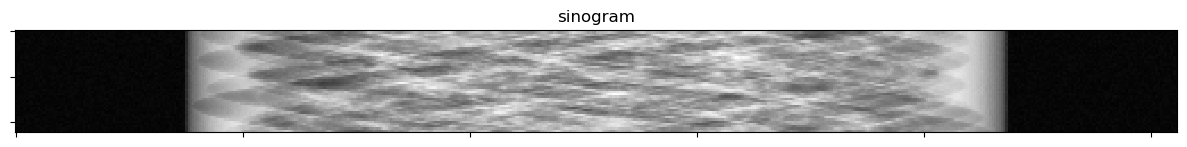

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(15, 3))
plot.imview(y, title="sinogram", fig=fig, ax=ax)
fig.show()

Plot convergence statistics.

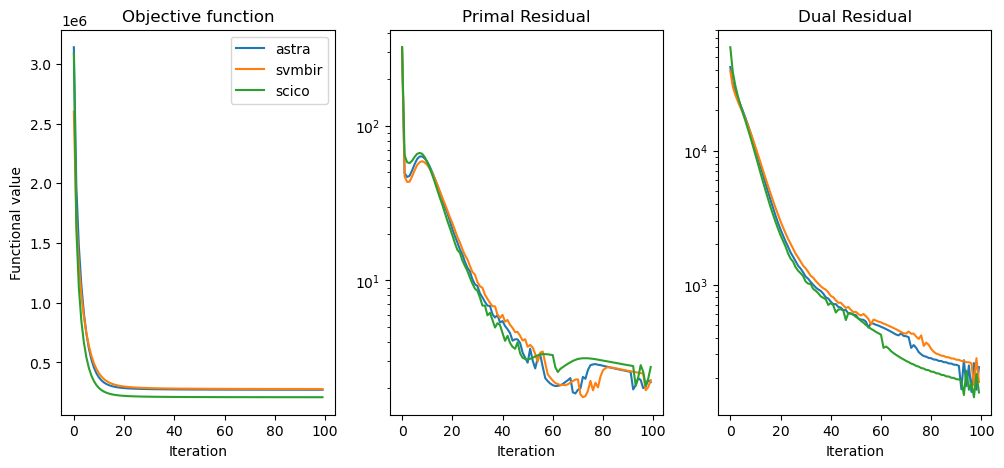

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

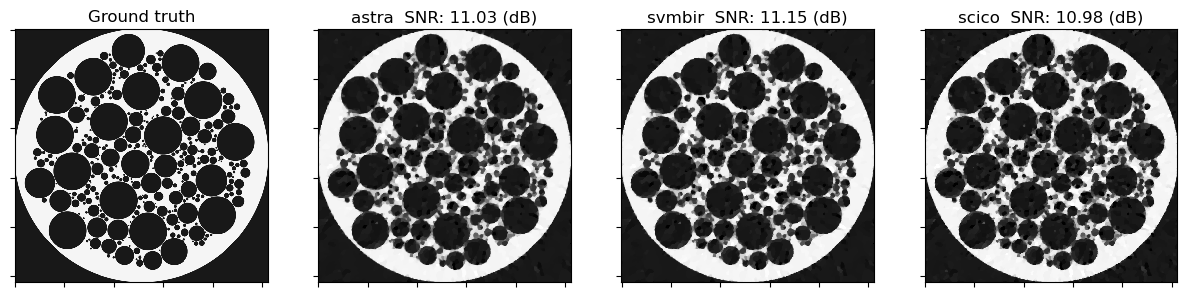

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
for ax in ax:
    ax.get_images()[0].set_clim(-0.1, 1.1)
fig.show()